In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [4]:
data = pd.read_csv("StudentCleaned.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       984 non-null    int64  
 1   parental level of education  984 non-null    int64  
 2   lunch                        984 non-null    int64  
 3   test preparation course      984 non-null    int64  
 4   race/ethnicity_group B       984 non-null    bool   
 5   race/ethnicity_group C       984 non-null    bool   
 6   race/ethnicity_group D       984 non-null    bool   
 7   race/ethnicity_group E       984 non-null    bool   
 8   avg_score                    984 non-null    float64
dtypes: bool(4), float64(1), int64(4)
memory usage: 42.4 KB


In [6]:
X = data.drop("avg_score", axis=1)
y = data['avg_score'].values.reshape(-1, 1)

In [7]:
X.shape, y.shape

((984, 8), (984, 1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [10]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [22]:
## Define Model Class
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden1 = 64, hidden2=32, dropout1=0.3, dropout2=0.2):
        super(NeuralNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout2),
            nn.Linear(hidden2,1)
        )
    def forward(self,x):
        return self.network(x)

In [23]:
##Hyper Parameter Search Space
param_grid = {
    'lr': [0.01, 0.001],
    'weight_decay': [1e-3, 1e-4],
    'dropout1': [0.3, 0.5],
    'dropout2': [0.2, 0.4]
}

In [24]:
best_val_loss = float('inf')
best_params = None
best_model_state = None
input_dim = X_train.shape[1]

In [26]:
#ManualGridSearch
for lr in param_grid['lr']:
    for wd in param_grid['weight_decay']:
        for d1 in param_grid['dropout1']:
            for d2 in param_grid['dropout2']:
                model = NeuralNet(input_dim, dropout1=d1, dropout2=d2)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                train_losses, val_losses = [], []
                epochs = 150

                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_train)
                    loss = criterion(outputs, y_train)
                    loss.backward()
                    optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        val_pred = model(X_test)
                        val_loss = criterion(val_pred, y_test)
                    train_losses.append(loss.item())
                    val_losses.append(val_loss.item())
            avg_val_loss = sum(val_losses[-10:])/10
            print(f"Params (lr={lr}, wd={wd}, d1={d1}, d2={d2}) → Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_params = (lr, wd,d1,d2)
                best_model_state = model.state_dict()
                best_train_losses = train_losses
                best_val_losses = val_losses


                    


Params (lr=0.01, wd=0.001, d1=0.3, d2=0.4) → Val Loss: 190.9352
Params (lr=0.01, wd=0.001, d1=0.5, d2=0.4) → Val Loss: 192.1663
Params (lr=0.01, wd=0.0001, d1=0.3, d2=0.4) → Val Loss: 186.0407
Params (lr=0.01, wd=0.0001, d1=0.5, d2=0.4) → Val Loss: 191.0172
Params (lr=0.001, wd=0.001, d1=0.3, d2=0.4) → Val Loss: 1085.4751
Params (lr=0.001, wd=0.001, d1=0.5, d2=0.4) → Val Loss: 906.3257
Params (lr=0.001, wd=0.0001, d1=0.3, d2=0.4) → Val Loss: 1304.6209
Params (lr=0.001, wd=0.0001, d1=0.5, d2=0.4) → Val Loss: 1050.6734


In [27]:

print(f"\n✅ Best Parameters: lr={best_params[0]}, wd={best_params[1]}, d1={best_params[2]}, d2={best_params[3]}")
print(f"✅ Best Validation Loss: {best_val_loss:.4f}")



✅ Best Parameters: lr=0.01, wd=0.0001, d1=0.3, d2=0.4
✅ Best Validation Loss: 186.0407


In [28]:
final_model = NeuralNet(input_dim, dropout1=best_params[2], dropout2=best_params[3])
final_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [29]:
#Save model
torch.save(final_model.state_dict(), 'neural_regressor.pth')
print("✅ PyTorch model saved as 'neural_regressor.pth'")

✅ PyTorch model saved as 'neural_regressor.pth'


In [30]:
#Convert to Pickle (for AWS or non-PyTorch deployment)
with open('neural_regressor.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("✅ Model also saved as 'neural_regressor.pkl'")

✅ Model also saved as 'neural_regressor.pkl'


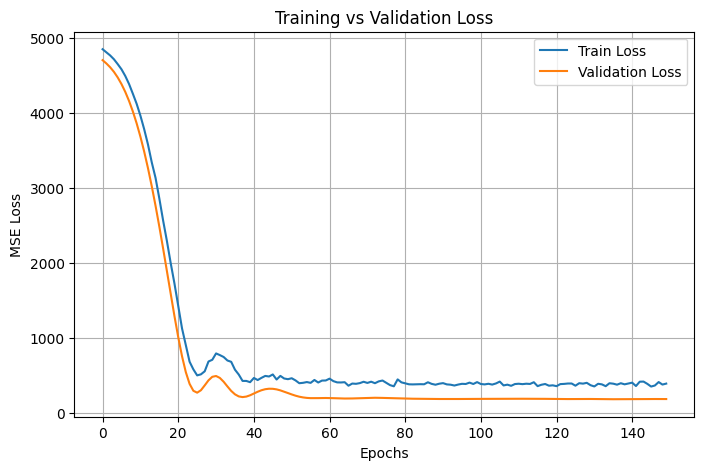

In [31]:
# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()